# Project 242

## Import

In [1]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

## I. Data

### 1. Load data

In [4]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

### 2. Preprocess data

- clean data
- add features

In [5]:
# Clean data
data = clean_data(data)

Here, we can decide to add features ...

In [6]:
# Add features
#data = add_technical_indicators(data, lookback_period=30)

In [7]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29958, 5) | X_test: (9986, 5)


In [8]:
# Scale data
#train_data, test_data = scale_data(train_data, test_data)

In [9]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [10]:
display(train_data.head(2))
display(test_data.head(2))

,open,high,low,close,Volume USDT,Return
0,16199.91,16199.91,4261.32,4308.83,190952.85,0.001506
1,4308.83,4328.69,4291.37,4315.32,100304.82,0.002093


,open,high,low,close,Volume USDT,Return
0,13126.54,13130.0,13080.00,13103.66,1.465144e+07,0.001113
1,13103.66,13130.0,13072.81,13118.24,1.492221e+07,0.000000


## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [11]:
train_data = train_data.dropna()

In [12]:
test_data = test_data.dropna()

In [13]:
X_train, _, y_train = prepare_data_for_training(train_data, lookback_period=10, signal=False)
X_test, _, y_test = prepare_data_for_training(test_data, lookback_period=10, signal=False)

In [14]:
X_train.shape, y_train.shape

((29947, 10, 5), (29947,))

### 2. Build model

The ultimate goal of this section is to build a model that builds a **prediction**.

This section may require a phase of **feature selection**.

...

In [15]:
#Initialize the LSTM
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) 

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train, epochs = 20, batch_size = 50)

Epoch 1/20
599/599 [==============================] - 8s 10ms/step - loss: 80758759424.0000
Epoch 2/20
599/599 [==============================] - 7s 12ms/step - loss: 2165593344.0000
Epoch 3/20
599/599 [==============================] - 6s 9ms/step - loss: 634598400.0000
Epoch 4/20
599/599 [==============================] - 6s 10ms/step - loss: 140186992.0000
Epoch 5/20
599/599 [==============================] - 5s 9ms/step - loss: 57848976.0000
Epoch 6/20
599/599 [==============================] - 4s 7ms/step - loss: 31509536.0000
Epoch 7/20
599/599 [==============================] - 5s 9ms/step - loss: 2012061184.0000
Epoch 8/20
599/599 [==============================] - 6s 10ms/step - loss: 25719076.0000
Epoch 9/20
599/599 [==============================] - 6s 10ms/step - loss: 940502.5000
Epoch 10/20
599/599 [==============================] - 6s 10ms/step - loss: 275665.6875
Epoch 11/20
599/599 [==============================] - 6s 10ms/step - loss: 102683.0703
Epoch 12/20
599/599 

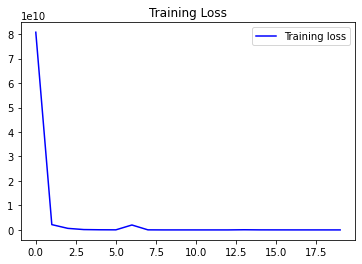

In [17]:
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training Loss")
plt.legend()
plt.show()

In [18]:
y_pred = model.predict(X_test) 
y_pred.shape, y_test.shape

((9975, 1), (9975,))

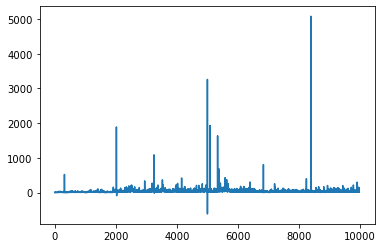

In [19]:
plt.plot(y_pred)

In [20]:
# Add Signal
q_90 = np.quantile(abs(y_pred), 0.9)

df_pred = pd.DataFrame(y_pred, columns=['Return'])

df_pred = add_signal(df_pred, q_90)

In [21]:
test_pos, test_neg = round((df_pred.Signal>0).sum()/df_pred.Signal.shape[0],2)*100, round((df_pred.Signal<0).sum()/df_pred.Signal.shape[0],2)*100

print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

Test set: 1 (10.0%) | 0 (90.0%) | -1 (0.0%)


In [22]:
y_pred = df_pred.Signal

### 3. Test prediction model

The ultimate goal of this section is to test our model in terms of **prediction metrics**.

In [26]:
y_test = pd.Series(y_test)

### III. Strategy

The ultimate goal of this section is to test our model in terms of **performance metrics** (while trading in simulating environment).

### 1. Get data ready for backtesting

In [27]:
signal = y_pred 
close = test_data.close.iloc[10:].reset_index(drop=True)

In [28]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [29]:
strat = Strategy(cash=500, fees=0.001)

In [30]:
strat.run(signal_crop, close_crop, verbose=False)

In [31]:
wallet = np.array(strat.wallet)
profit = wallet[:-1] - wallet[1:]

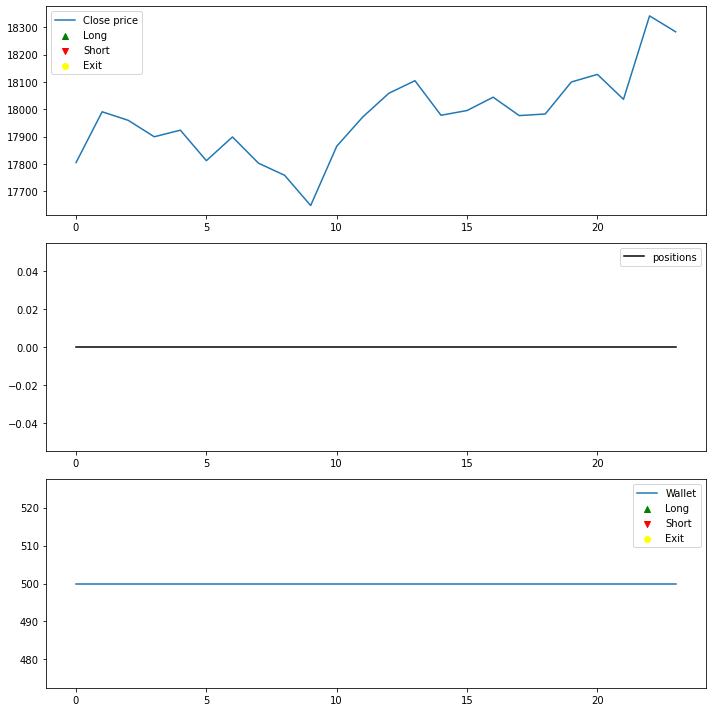

In [32]:
strat.visualize()

### 3. Test performance startegy

In [33]:
SharpeRatio = SharpeRatio(profit)
MaxDrawback = MaxDrawback(profit)
WinLossRatio = WinLossRatio(profit)
CumulativeProfit = CumulativeProfit(profit)
MeanProfit = MeanProfit(profit)

C:\Users\thiba\OneDrive\Bureau\Berkeley\242_Data_Applications\Project\INDENG-242-project\modules\metrics_performance.py:26: RuntimeWarning: invalid value encountered in double_scalars
  return mean_profit/var_profit
C:\Users\thiba\OneDrive\Bureau\Berkeley\242_Data_Applications\Project\INDENG-242-project\modules\metrics_performance.py:37: RuntimeWarning: invalid value encountered in long_scalars
  return win/loss


In [34]:
models = ['Baseline']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[SharpeRatio, MaxDrawback, WinLossRatio, CumulativeProfit, MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
Baseline,NaN,0.0,NaN,0.0,0.0
